In [1]:
import os
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
import os
from torchvision.utils import make_grid

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import kagglehub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [4]:
data_dir = os.path.join(path, 'Garbage classification', 'Garbage classification')

In [5]:
classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = ImageFolder(root=data_dir, transform=transform)

In [7]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
len(dataset)

2527

In [10]:
total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [11]:
len(train_ds), len(val_ds), len(test_ds)

(1768, 379, 380)

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

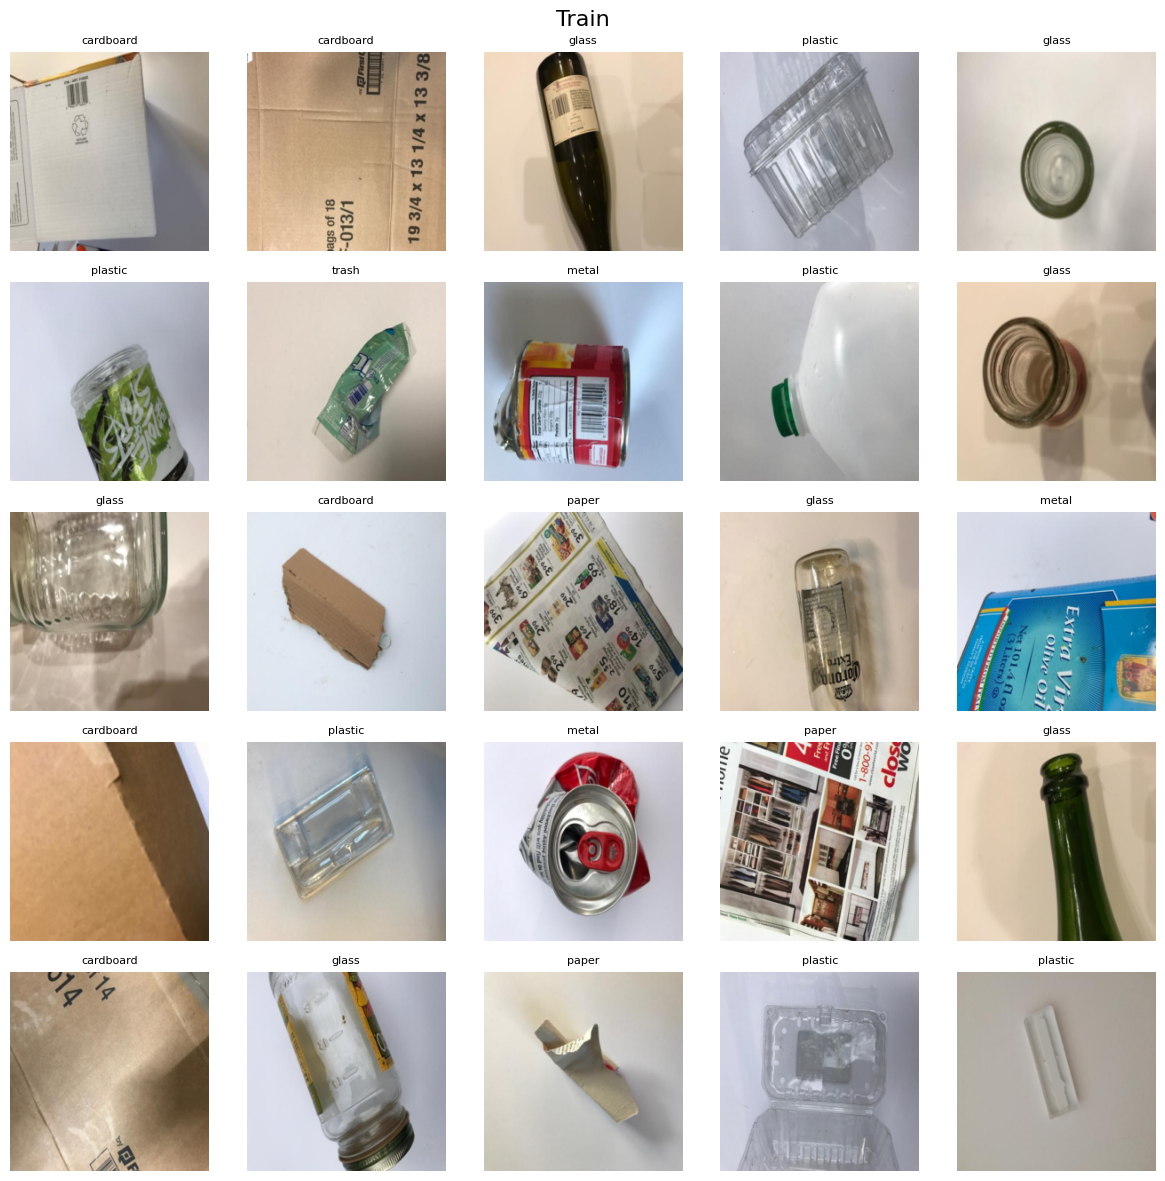

In [13]:
import numpy as np

size = 5
fig, axs = plt.subplots(size, size, figsize=(12,12))
indexes = np.random.randint(0, len(train_loader.dataset), size*size)
fig.suptitle("Train", fontsize=16)

for i in range(size):
    for j in range(size):
        idx = indexes[i * size + j]
        image, label = train_loader.dataset[idx]
        image = image.permute(1, 2, 0)
        image = image.clip(0, 1)

        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(train_loader.dataset.dataset.classes[label], fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(labels_all, preds_all, average='macro')
    return epoch_loss, epoch_f1


def train_model(model, name, train_loader, val_loader, device, epochs=10, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {
        'train_losses': [], 'train_f1': [],
        'val_losses': [], 'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        preds_all = []
        labels_all = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_f1 = f1_score(labels_all, preds_all, average='macro')

        # Validation
        val_loss, val_f1 = evaluate(model, val_loader, criterion, device)

        history['train_losses'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_losses'].append(val_loss)
        history['val_f1'].append(val_f1)

        scheduler.step()

        print(f"[{name}] Epoch {epoch+1}/{epochs} — "
              f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history

In [15]:
def resnet50_random(num_classes=6):
    model = models.resnet50(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def resnet50_transfer(num_classes=6):
    model = models.resnet50(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [16]:
def vgg16_random(num_classes=6):
    model = models.vgg16(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model


def vgg16_transfer(num_classes=6):
    model = models.vgg16(weights='IMAGENET1K_V1')

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

In [17]:
def resnet18_random(num_classes=6):
    model = models.resnet18(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def resnet18_transfer(num_classes=6):
    model = models.resnet18(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [18]:
def alexnet_random(num_classes=6):
    model = models.alexnet(weights=None)

    for param in model.parameters():
        param.requires_grad = True

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

def alexnet_transfer(num_classes=6):
    model = models.alexnet(weights='IMAGENET1K_V1')
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

In [19]:
models_to_run = [
    ("VGG16 Random", vgg16_random()),
    ("VGG16 Transfer", vgg16_transfer()),
    ("ResNet18 Random", resnet18_random()),
    ("ResNet18 Transfer", resnet18_transfer()),
    ("AlexNet Random", alexnet_random()),
    ("AlexNet Transfer", alexnet_transfer()),
    ("ResNet50 Random", resnet50_random()),
    ("ResNet50 Transfer", resnet50_transfer()),
]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 75.1MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 180MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


In [20]:
results = {}
epochs = 20

for name, model in models_to_run:
    print("\n")
    print("Training:", name)

    history = train_model(model, name, train_loader, val_loader, device, epochs, lr=0.001)
    test_loss, test_f1 = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)

    results[name] = {'history': history, 'test_f1': test_f1, 'test_loss': test_loss}
    print(f"{name} Test F1: {test_f1:.4f}")



Training: VGG16 Random
[VGG16 Random] Epoch 1/20 — Train Loss: 9.0957, Train F1: 0.1350, Val Loss: 1.7390, Val F1: 0.0599
[VGG16 Random] Epoch 2/20 — Train Loss: 1.7277, Train F1: 0.1005, Val Loss: 1.7441, Val F1: 0.0599
[VGG16 Random] Epoch 3/20 — Train Loss: 1.7247, Train F1: 0.0867, Val Loss: 1.7393, Val F1: 0.0599
[VGG16 Random] Epoch 4/20 — Train Loss: 1.7238, Train F1: 0.0645, Val Loss: 1.7383, Val F1: 0.0599
[VGG16 Random] Epoch 5/20 — Train Loss: 1.7216, Train F1: 0.0638, Val Loss: 1.7420, Val F1: 0.0599
[VGG16 Random] Epoch 6/20 — Train Loss: 1.7187, Train F1: 0.0639, Val Loss: 1.7407, Val F1: 0.0599
[VGG16 Random] Epoch 7/20 — Train Loss: 1.7187, Train F1: 0.0639, Val Loss: 1.7409, Val F1: 0.0599
[VGG16 Random] Epoch 8/20 — Train Loss: 1.7180, Train F1: 0.0639, Val Loss: 1.7408, Val F1: 0.0599
[VGG16 Random] Epoch 9/20 — Train Loss: 1.7187, Train F1: 0.0639, Val Loss: 1.7409, Val F1: 0.0599
[VGG16 Random] Epoch 10/20 — Train Loss: 1.7189, Train F1: 0.0639, Val Loss: 1.7408,

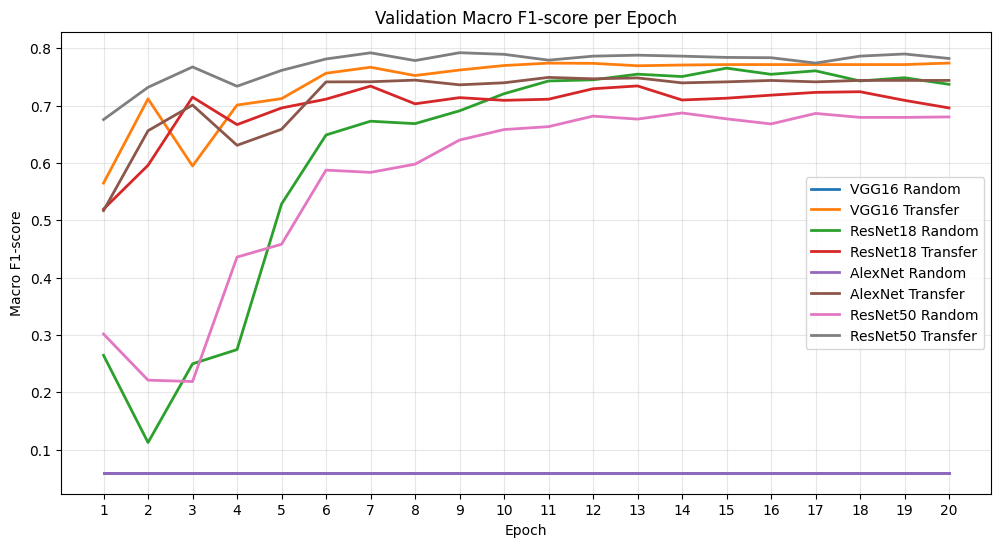

In [21]:
plt.figure(figsize=(12, 6))

for name, result in results.items():
    val_f1_scores = result['history']['val_f1']
    plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label=name, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Macro F1-score')
plt.title('Validation Macro F1-score per Epoch')
plt.xticks(range(1, epochs + 1))  # Сделать ось X = 1..20
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


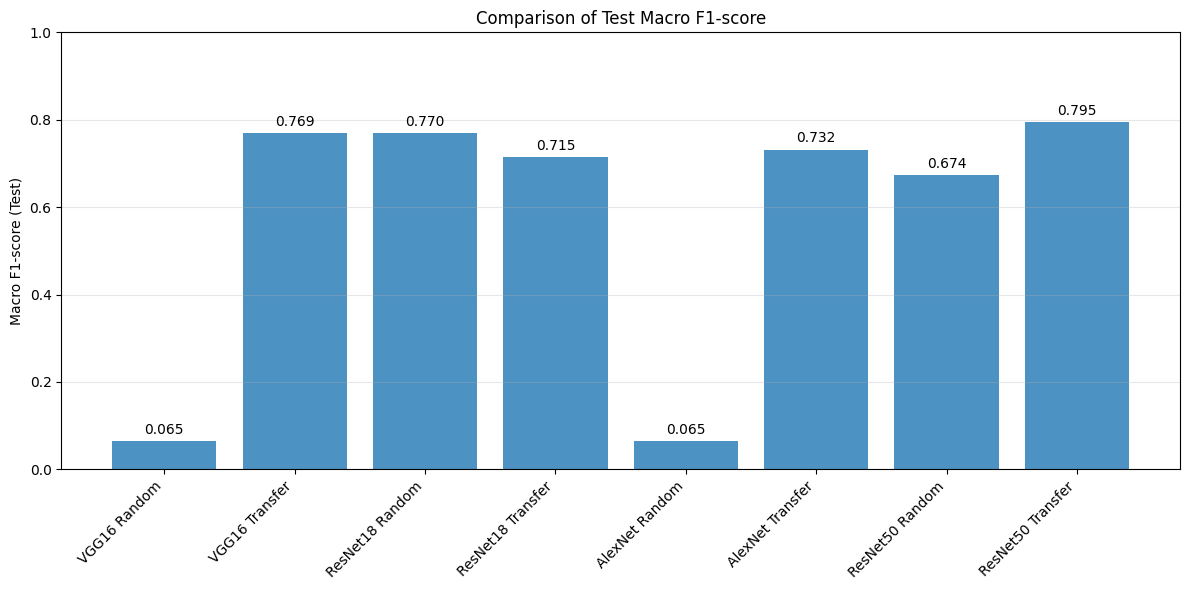

In [22]:
model_names = list(results.keys())
test_scores = [results[name]['test_f1'] for name in model_names]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, test_scores, alpha=0.8)

plt.ylabel('Macro F1-score (Test)')
plt.title('Comparison of Test Macro F1-score')
plt.xticks(rotation=45, ha='right')

for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom')

plt.ylim(0, 1.0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
for name, model in models_to_run:
    print(f"MODEL ARCHITECTURE: {name}")
    print(model)

MODEL ARCHITECTURE: VGG16 Random
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

In [24]:
from torchsummary import summary

for name, model in models_to_run:
    print(f"SUMMARY: {name}")
    summary(model, (3, 224, 224))

SUMMARY: VGG16 Random
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU